In [1]:
import os
os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [3]:
import json

In [4]:
import ast

import ast_scope
import pandas as pd
import requests
import tqdm.auto as tqdm
import neurosym as ns
import matplotlib.pyplot as plt

from imperative_stitch.compress.julia_stitch import run_julia_stitch
from imperative_stitch.compress.abstraction import Abstraction
from imperative_stitch.compress.manipulate_abstraction import (
    abstraction_calls_to_bodies,
    abstraction_calls_to_bodies_recursively,
    abstraction_calls_to_stubs,
    collect_abstraction_calls,
    replace_abstraction_calls,
)
from imperative_stitch.data.github_repository_downloader import (
    single_repo_random_subset_of_size,
    one_each,
    multiple_repos_random_subset_of_size,
)

In [5]:
from imperative_stitch.utils.remove_docstrings import remove_docstrings
from imperative_stitch.experiments.compression_hyperparameter_search.datasets import (
    datasets,
    sizes,
    datasets_for_size,
)

from imperative_stitch.experiments.compression_hyperparameter_search.run_stitch import (
    run_stitch_with_hyperparameters,
)
from imperative_stitch.experiments.compression_hyperparameter_search.run_experiment import (
    run_experiment_up_to_seed,
    with_only_2_min_matches,
)
from imperative_stitch.experiments.compression_hyperparameter_search.analysis import *

In [6]:
d = datasets()

In [7]:
rs = run_experiment_up_to_seed(20, with_only_2_min_matches, skip_missing=True)

  0%|          | 0/300 [00:00<?, ?it/s]

Skipping ('ml_repo', 1000000) with seed 1
Skipping ('ml_repo', 1000000) with seed 0
Skipping ('ml_repo', 1000000) with seed 4
Skipping ('ml_repo', 1000000) with seed 5
Skipping ('ml_repo', 1000000) with seed 3
Skipping ('ml_repo', 1000000) with seed 6
Skipping ('ml_repo', 1000000) with seed 7
Skipping ('ml_repo', 1000000) with seed 8
Skipping ('ml_repo', 1000000) with seed 9
Skipping ('ml_repo', 1000000) with seed 13
Skipping ('ml_repo', 1000000) with seed 14
Skipping ('ml_repo', 1000000) with seed 12
Skipping ('ml_repo', 1000000) with seed 18
Skipping ('ml_repo', 1000000) with seed 19


In [8]:
keys_in_all = sorted(set.intersection(*({k for k in r if r[k] != None} for r in rs)))

In [9]:
max_iters = 10

In [10]:
num_abstractions = []
length_abstractions = []
saturateds = []
for r in rs:
    num_abs, len_abs, saturated = 0, 0, 0
    for k in keys_in_all:
        _, codes, _ = extract_code(r[k])
        num_abs += len(codes)
        len_abs += sum(len(c) for c in codes)
        assert len(codes) <= max_iters
        saturated += len(codes) == max_iters
    num_abstractions.append(num_abs)
    length_abstractions.append(len_abs)
    saturateds.append(saturated / len(keys_in_all))

In [11]:
# subjective_scores = [None] * len(rs)

In [12]:
# print_out_abstractions(16, rs[16])
# subjective_scores[0] = "B", "several created examples. some seem too small"

In [13]:
# subjective_scores_grade, subjective_scores_desc = zip(*subjective_scores)

In [14]:
results = pd.DataFrame(
    {
        i: {
            **with_only_2_min_matches(i),
            **{("wall_time", *k): wall_time(v) for k, v in r.items()},
            **{("compression", *k): s_exp_compression(v) for k, v in r.items()},
            "num_abstractions": num_abstractions[i],
            "len_abstractions": length_abstractions[i],
            "saturated": saturateds[i],
            # "grade": subjective_scores_grade[i],
            # "description": subjective_scores_desc[i],
        }
        for i, r in enumerate(rs)
    }
).T
results_no_infcol = results[
    [
        x
        for x in results
        if not isinstance(x, tuple) or np.isfinite(list(results[x])).all()
    ]
]
mean_by_repo_size = {x[1:]: np.mean(results[x]) for x in results if x[0] == "wall_time"}

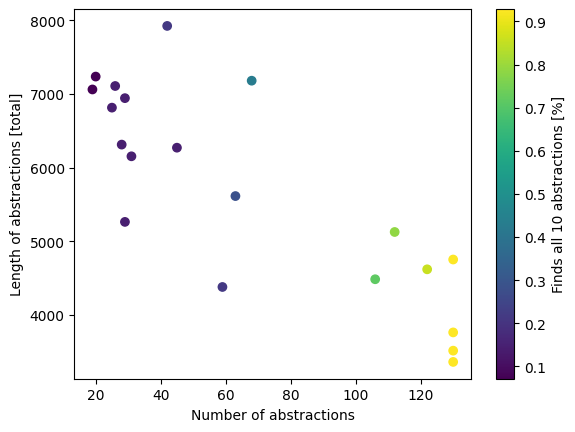

In [15]:
plt.scatter(results.num_abstractions, results.len_abstractions, c=saturateds)
plt.colorbar(label="Finds all 10 abstractions [%]")
plt.xlabel("Number of abstractions")
plt.ylabel("Length of abstractions [total]")
plt.show()

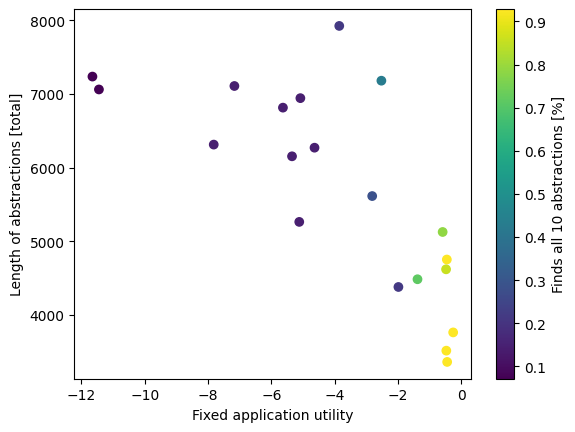

In [16]:
plt.scatter(results.application_utility_fixed, results.len_abstractions, c=saturateds)
plt.colorbar(label="Finds all 10 abstractions [%]")
plt.xlabel("Fixed application utility")
plt.ylabel("Length of abstractions [total]")
plt.show()